<a href="https://colab.research.google.com/github/patriani/RNN_LSTM_Tesla_stock/blob/main/ELT575_Semana3_ES119663.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [3]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import pandas as pd

# Primeira configuração da rede
- **Modelo**: RNN configurado com apenas uma célula de LSTM, que por sua vez possui 50 unidades ocultas.

```
Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)
 Trainable params: 10,451 (40.82 KB)
 Non-trainable params: 0 (0.00 B)
 Optimizer params: 20,904 (81.66 KB)

```


- **Análise**: De forma geral, observaremos que o desempenho dos modelos é melhor quando em treino do que quando em teste, assim como se costuma observar na ciência de dados como um todo. O que este modelo nos apresentou mais particularmente foi uma leve melhoria para uma maior quantidade de épocas, em que o teste com epochs=50 apresentou a menor perda dos cenários de teste, assim como também ouve uma redução na perda observada durante o treinamento do modelo.



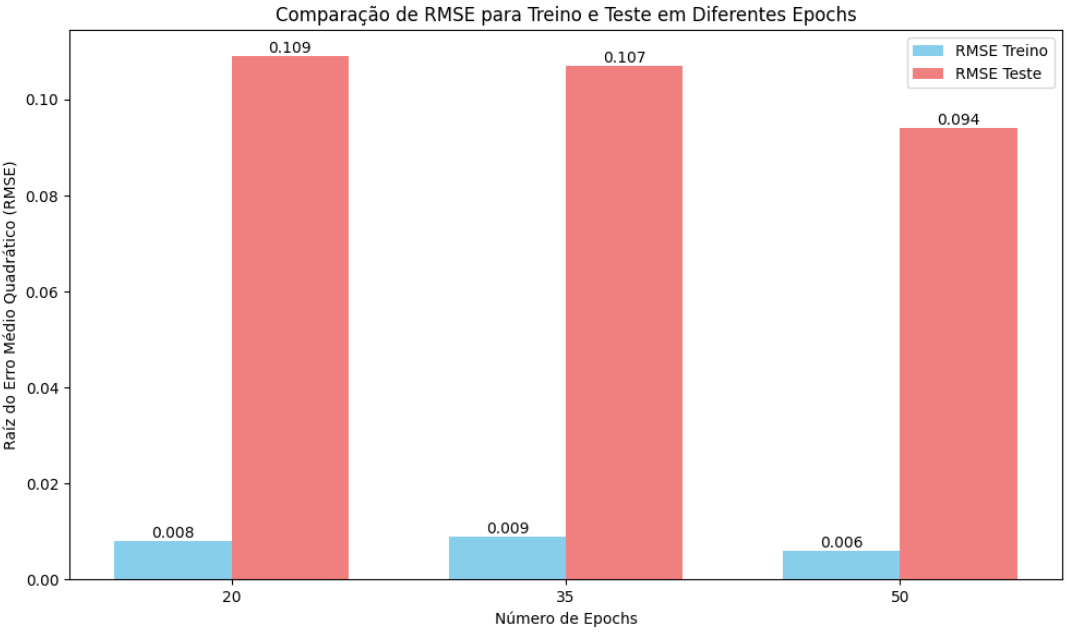

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
def load_and_prepare_data():

  tesla_stock = 'https://raw.githubusercontent.com/patriani/RNN_LSTM_Tesla_stock/main/tesla_stock_2015_2022.csv'
  df = read_csv(tesla_stock)

  # Only the column 'Open' will be used as independent variables and 'Close' is the column of the dependent variables.
  #df_XY=pd.DataFrame(df, columns=['Open','Close'])
  opening_prices = df['Open'].values

  # Reshape of the target data
  opening_prices_scaled = scaler.fit_transform(opening_prices.reshape(-1, 1))

  # Split into train and test data (80% to train and 20% to test)
  train_size = int(len(opening_prices_scaled) * 0.8)
  train_data = opening_prices_scaled[:train_size]
  test_data = opening_prices_scaled[train_size:]

  return opening_prices,train_data,test_data

opening_prices,train_data,test_data = load_and_prepare_data()

In [5]:
# Prepare the input X and target Y for temporal analysis

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i])
        labels.append(data[i])
    return np.array(sequences), np.array(labels)


time_steps = 50

# Prepating the train data frame
trainX, trainY = create_sequences(train_data, time_steps)

# Prepating the test data frame
testX, testY = create_sequences(test_data, time_steps)

In [6]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=32, verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
40/40 - 3s - 87ms/step - loss: 8.8200e-04 - val_loss: 0.0148
Epoch 2/50
40/40 - 0s - 12ms/step - loss: 1.5132e-04 - val_loss: 0.0087
Epoch 3/50
40/40 - 1s - 13ms/step - loss: 1.1764e-04 - val_loss: 0.0084
Epoch 4/50
40/40 - 0s - 9ms/step - loss: 1.0976e-04 - val_loss: 0.0077
Epoch 5/50
40/40 - 1s - 14ms/step - loss: 1.0756e-04 - val_loss: 0.0093
Epoch 6/50
40/40 - 0s - 8ms/step - loss: 1.0636e-04 - val_loss: 0.0104
Epoch 7/50
40/40 - 0s - 8ms/step - loss: 9.5910e-05 - val_loss: 0.0084
Epoch 8/50
40/40 - 1s - 14ms/step - loss: 9.5459e-05 - val_loss: 0.0072
Epoch 9/50
40/40 - 1s - 14ms/step - loss: 8.9765e-05 - val_loss: 0.0063
Epoch 10/50
40/40 - 0s - 12ms/step - loss: 9.0402e-05 - val_loss: 0.0092
Epoch 11/50
40/40 - 1s - 14ms/step - loss: 8.8310e-05 - val_loss: 0.0109
Epoch 12/50
40/40 - 1s - 16ms/step - loss: 8.8564e-05 - val_loss: 0.0089
Epoch 13/50
40/40 - 1s - 14ms/step - loss: 8.0814e-05 - val_loss: 0.0083
Epoch 14/50
40/40 - 1s - 17ms/step - loss: 7.6027e-05 - val_los

In [7]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Raíz do Erro Médio Quadrático para Treino: 0.006
Raíz do Erro Médio Quadrático para Teste: 0.094


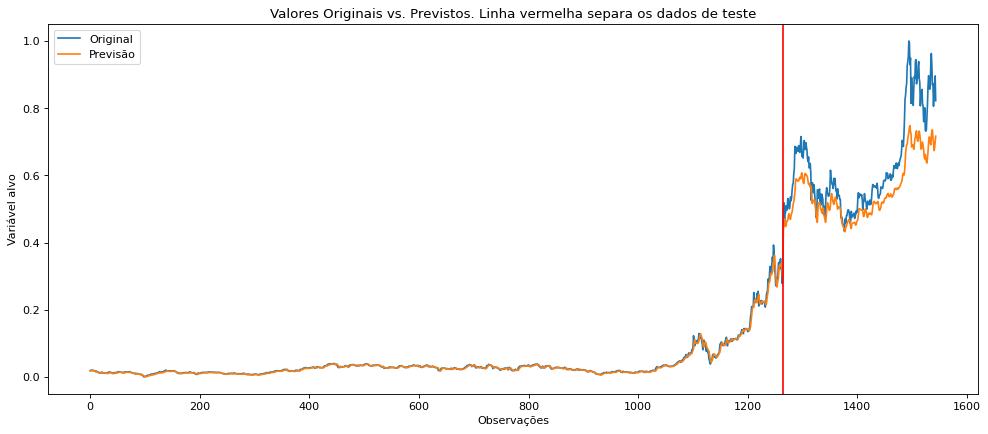

In [8]:

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Variável alvo')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')

plot_result(trainY, testY, train_predict, test_predict)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

# Segunda análise
- **Modelo**: baseado no primeiro experimento, com adição de uma camada LSTM

```
Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)
 Trainable params: 30,651 (119.73 KB)
 Non-trainable params: 0 (0.00 B)
 Optimizer params: 61,304 (239.47 KB)

```

- **Análise**: A adição e conexão de uma camada LSTM já contribuiu levemente na generalização do modelo, assim como aumentou a precisão dele devido a redução do RMSE para o caso de 35 épocas. Assim que o número de épocas volta a aumentar, o modelo apresenta aumento sugnificativo na perda durante o teste, o que configura um decaimento de generalização e tendência a overfitting.

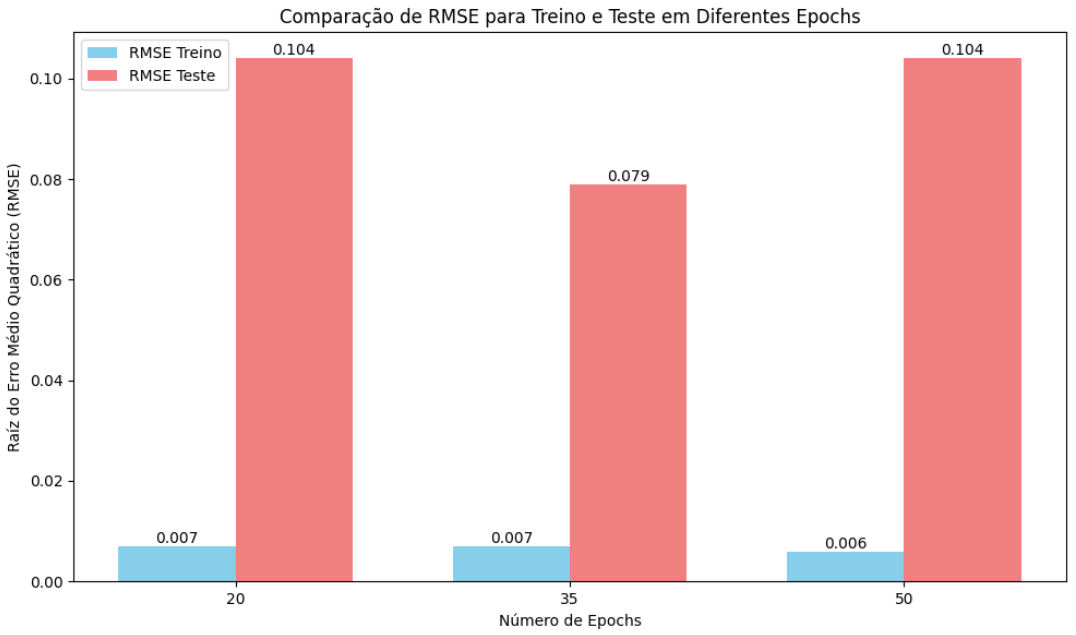

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 2s - 60ms/step - loss: 8.1453e-04 - val_loss: 0.0074
Epoch 2/50
40/40 - 1s - 22ms/step - loss: 1.2433e-04 - val_loss: 0.0088
Epoch 3/50
40/40 - 0s - 9ms/step - loss: 1.3091e-04 - val_loss: 0.0077
Epoch 4/50
40/40 - 0s - 9ms/step - loss: 1.2146e-04 - val_loss: 0.0084
Epoch 5/50
40/40 - 0s - 10ms/step - loss: 1.1479e-04 - val_loss: 0.0103
Epoch 6/50
40/40 - 1s - 15ms/step - loss: 1.0176e-04 - val_loss: 0.0141
Epoch 7/50
40/40 - 0s - 9ms/step - loss: 1.0394e-04 - val_loss: 0.0094
Epoch 8/50
40/40 - 0s - 9ms/step - loss: 1.0414e-04 - val_loss: 0.0133
Epoch 9/50
40/40 - 1s - 16ms/step - loss: 1.0130e-04 - val_loss: 0.0100
Epoch 10/50
40/40 - 1s - 18ms/step - loss: 1.0021e-04 - val_loss: 0.0205
Epoch 11/50
40/40 - 1s - 13ms/step - loss: 8.7557e-05 - val_loss: 0.0086
Epoch 12/50
40/40 - 1s - 18ms/step - loss: 8.2367e-05 - val_loss: 0.0098
Epoch 13/50
40/40 - 0s - 12ms/step - loss: 8.6357e-05 - val_loss: 0.0107
Epoch 14/50
40/40 - 1s - 17ms/step - loss: 8.1817e-05 - val_loss: 0.0078
Ep

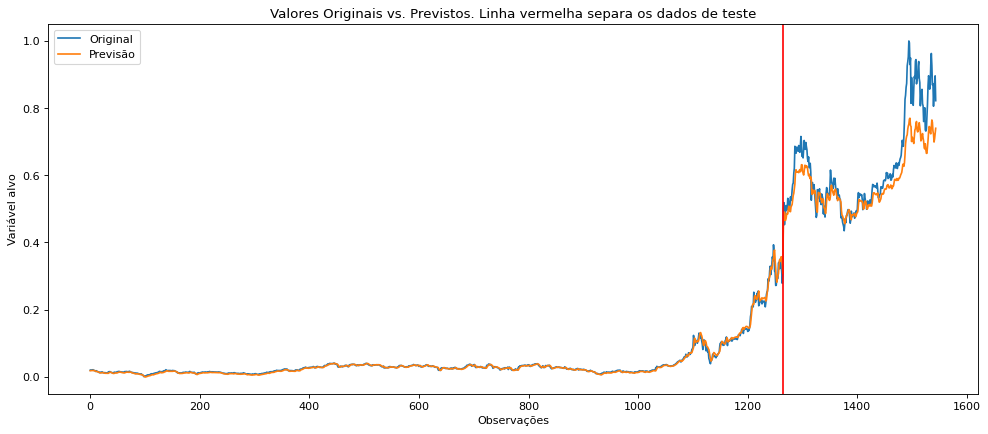

In [11]:

df_XY_02,train_data_02,test_data_02 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_02, trainY_02 = create_sequences(train_data_02, time_steps)

# Prepating the test data frame
testX_02, testY_02 = create_sequences(test_data_02, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[1]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_02 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_02.fit(trainX_02, trainY_02, validation_data=(testX_02, testY_02), epochs=50, batch_size=32, verbose=2)


# make predictions
train_predict_02 = model_02.predict(trainX_02)
test_predict_02 = model_02.predict(testX_02)
# Mean square error
print_error(trainY_02, testY_02, train_predict_02, test_predict_02)


# predicting
predicted_02 = model_02.predict(trainX_02)
predicted_prices_02 = scaler.inverse_transform(predicted_02)
actual_prices_02 = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot the result
plot_result(trainY_02, testY_02, train_predict_02, test_predict_02)

In [12]:
model_02.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

# Terceira análise
- **Modelo:** baseado no modelo anterior, tendo camadas de Dropout de 20% incluídas


```
Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)
 Trainable params: 30,651 (119.73 KB)
 Non-trainable params: 0 (0.00 B)
 Optimizer params: 61,304 (239.47 KB)

```

- **Análise:** Observa-se que as métricas de erro não foram consideravelmente menores do que o exemplo anterior apresentou. Presumi-se que a técnica de dropout não contribui diretamente na melhora de performance de modelos pequenos, mas que é uma técnica promissora para redes mais profundas (com mais camdas), assim como será observado na próxima análise (quarta análise).

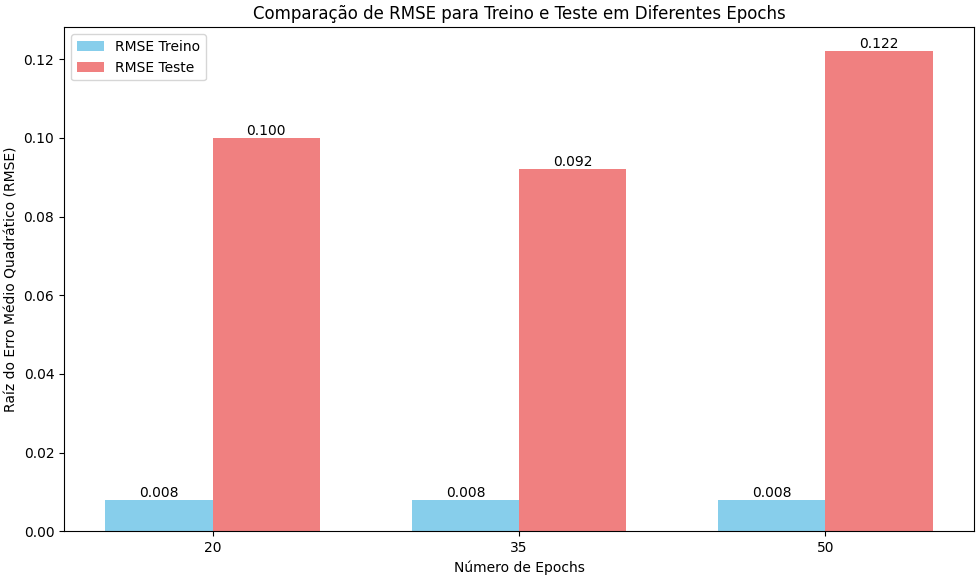

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 3s - 81ms/step - loss: 6.4161e-04 - val_loss: 0.0073
Epoch 2/50
40/40 - 0s - 10ms/step - loss: 1.7449e-04 - val_loss: 0.0144
Epoch 3/50
40/40 - 0s - 10ms/step - loss: 2.1164e-04 - val_loss: 0.0114
Epoch 4/50
40/40 - 0s - 10ms/step - loss: 1.7505e-04 - val_loss: 0.0253
Epoch 5/50
40/40 - 1s - 15ms/step - loss: 1.9006e-04 - val_loss: 0.0126
Epoch 6/50
40/40 - 0s - 10ms/step - loss: 1.4129e-04 - val_loss: 0.0092
Epoch 7/50
40/40 - 1s - 16ms/step - loss: 1.4091e-04 - val_loss: 0.0061
Epoch 8/50
40/40 - 0s - 10ms/step - loss: 1.3179e-04 - val_loss: 0.0170
Epoch 9/50
40/40 - 0s - 10ms/step - loss: 1.5648e-04 - val_loss: 0.0138
Epoch 10/50
40/40 - 1s - 15ms/step - loss: 1.1748e-04 - val_loss: 0.0078
Epoch 11/50
40/40 - 0s - 10ms/step - loss: 1.4124e-04 - val_loss: 0.0123
Epoch 12/50
40/40 - 0s - 9ms/step - loss: 1.3500e-04 - val_loss: 0.0087
Epoch 13/50
40/40 - 0s - 9ms/step - loss: 1.2776e-04 - val_loss: 0.0076
Epoch 14/50
40/40 - 1s - 16ms/step - loss: 1.0081e-04 - val_loss: 0.0126


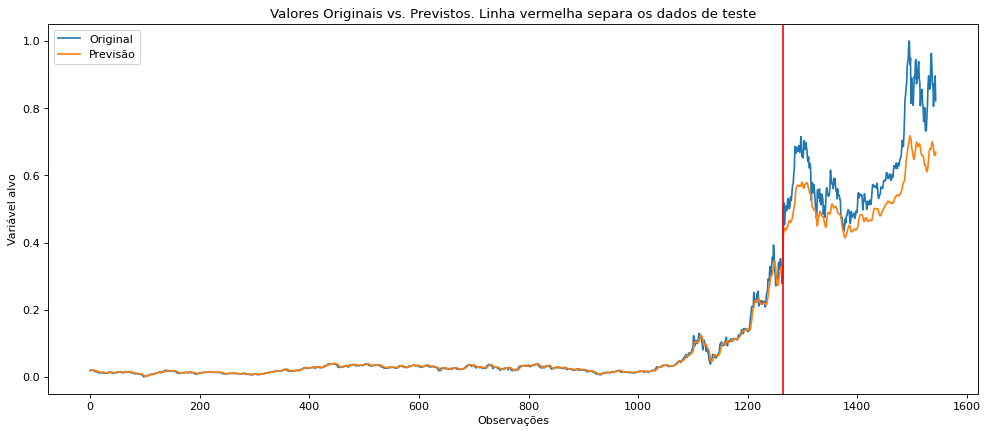

In [14]:

df_XY_03,train_data_03,test_data_03 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_03, trainY_03 = create_sequences(train_data_03, time_steps)

# Prepating the test data frame
testX_03, testY_03 = create_sequences(test_data_03, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_03 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_03.fit(trainX_03, trainY_03, validation_data=(testX_03, testY_03), epochs=50, batch_size=32, verbose=2)


# make predictions
train_predict_03 = model_03.predict(trainX_03)
test_predict_03 = model_03.predict(testX_03)
# Mean square error
print_error(trainY_03, testY_03, train_predict_03, test_predict_03)

# Plot the result
plot_result(trainY_03, testY_03, train_predict_03, test_predict_03)

In [15]:
model_03.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

# Quarta análise
- modelo04: 4 blocos de LSTM, sendo que após cada um dos blocos foi inserido um Dropout de 20%

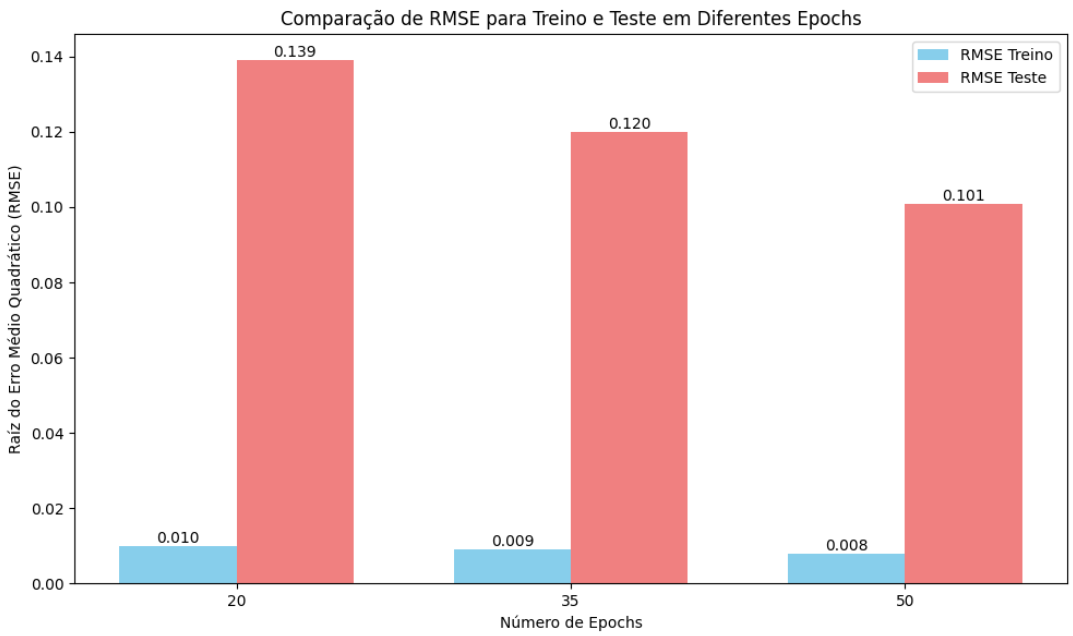

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 4s - 111ms/step - loss: 8.8472e-04 - val_loss: 0.0146
Epoch 2/50
40/40 - 1s - 17ms/step - loss: 2.7672e-04 - val_loss: 0.0091
Epoch 3/50
40/40 - 1s - 28ms/step - loss: 2.7197e-04 - val_loss: 0.0290
Epoch 4/50
40/40 - 1s - 15ms/step - loss: 2.2261e-04 - val_loss: 0.0178
Epoch 5/50
40/40 - 1s - 16ms/step - loss: 2.3772e-04 - val_loss: 0.0160
Epoch 6/50
40/40 - 1s - 16ms/step - loss: 2.5295e-04 - val_loss: 0.0159
Epoch 7/50
40/40 - 1s - 15ms/step - loss: 3.0329e-04 - val_loss: 0.0134
Epoch 8/50
40/40 - 1s - 16ms/step - loss: 2.2214e-04 - val_loss: 0.0165
Epoch 9/50
40/40 - 1s - 15ms/step - loss: 2.1032e-04 - val_loss: 0.0114
Epoch 10/50
40/40 - 1s - 14ms/step - loss: 2.5691e-04 - val_loss: 0.0127
Epoch 11/50
40/40 - 1s - 15ms/step - loss: 1.7865e-04 - val_loss: 0.0130
Epoch 12/50
40/40 - 1s - 13ms/step - loss: 2.4022e-04 - val_loss: 0.0130
Epoch 13/50
40/40 - 1s - 13ms/step - loss: 2.1332e-04 - val_loss: 0.0106
Epoch 14/50
40/40 - 1s - 15ms/step - loss: 2.0053e-04 - val_loss: 0.02

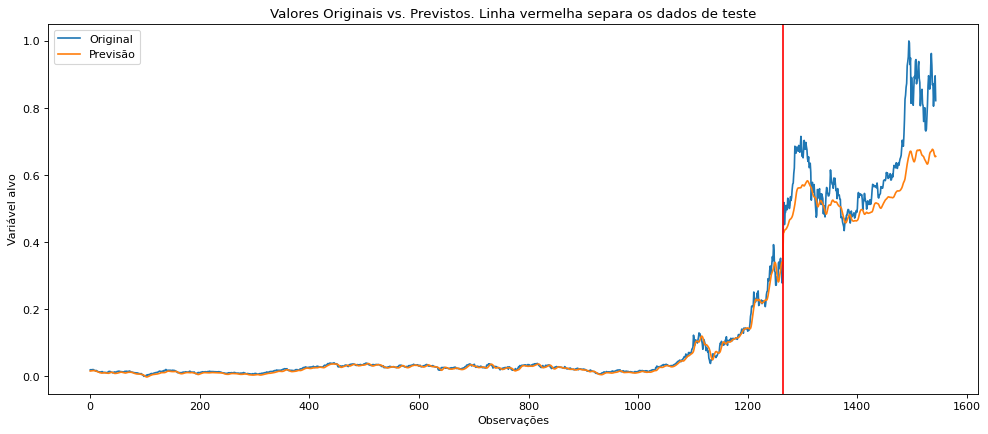

In [16]:

df_XY_04,train_data_04,test_data_04 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_04, trainY_04 = create_sequences(train_data_04, time_steps)

# Prepating the test data frame
testX_04, testY_04 = create_sequences(test_data_04, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[1],return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[1],return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_04 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_04.fit(trainX_04, trainY_04, validation_data=(testX_04, testY_04), epochs=50, batch_size=32, verbose=2)

# make predictions
train_predict_04 = model_04.predict(trainX_04)
test_predict_04 = model_04.predict(testX_04)
# Mean square error
print_error(trainY_04, testY_04, train_predict_04, test_predict_04)

# Plot the result
plot_result(trainY_04, testY_04, train_predict_04, test_predict_04)



In [17]:
model_04.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

# Apêndice
- Abaixo observamos o código utilizado na confeccão dos gráficos de barra utilizados para as conclusões das análises.

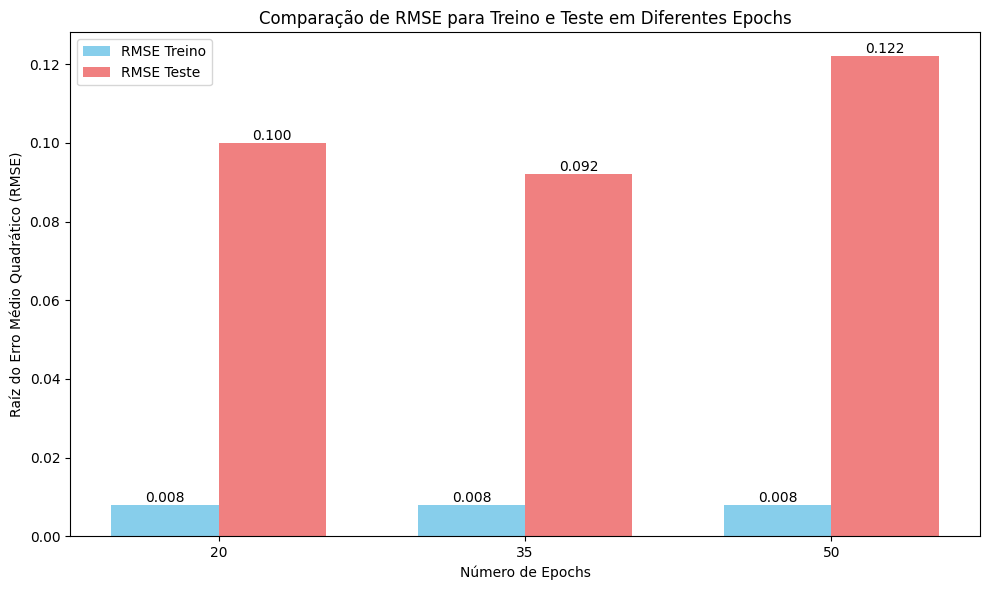

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def loss_bars(epochs,rmse_train,rmse_test):
  # Create a DataFrame
  data = {
      'Epochs': epochs,
      'RMSE Treino': rmse_train,
      'RMSE Teste': rmse_test
  }
  df_results = pd.DataFrame(data)

  # Plotting the bar chart
  fig, ax = plt.subplots(figsize=(10, 6))

  bar_width = 0.35
  index = np.arange(len(epochs))

  bar1 = ax.bar(index, df_results['RMSE Treino'], bar_width, label='RMSE Treino', color='skyblue')
  bar2 = ax.bar(index + bar_width, df_results['RMSE Teste'], bar_width, label='RMSE Teste', color='lightcoral')

  ax.set_xlabel('Número de Epochs')
  ax.set_ylabel('Raíz do Erro Médio Quadrático (RMSE)')
  ax.set_title('Comparação de RMSE para Treino e Teste em Diferentes Epochs')
  ax.set_xticks(index + bar_width / 2)
  ax.set_xticklabels(df_results['Epochs'])
  ax.legend()

  # Add value labels on top of the bars
  def autolabel(bars):
      for bar in bars:
          height = bar.get_height()
          ax.text(bar.get_x() + bar.get_width()/2., height,
                  '%.3f' % height,
                  ha='center', va='bottom')

  autolabel(bar1)
  autolabel(bar2)

  plt.tight_layout()
  plt.show()


epochs = [20, 35, 50]


### Análise 01
#epochs = 20
#Raíz do Erro Médio Quadrático para Treino: 0.008
#Raíz do Erro Médio Quadrático para Teste: 0.109
#
#epochs = 35
#Raíz do Erro Médio Quadrático para Treino: 0.008
#Raíz do Erro Médio Quadrático para Teste: 0.107
#
#epochs= 50
#Raíz do Erro Médio Quadrático para Treino: 0.006
#Raíz do Erro Médio Quadrático para Teste: 0.094

rmse_train = [0.008, 0.009, 0.006]
rmse_test = [0.109, 0.107, 0.094]
#loss_bars(epochs,rmse_train,rmse_test)



## Análise02
#epochs = 20
#Raíz do Erro Médio Quadrático para Treino: 0.007
#Raíz do Erro Médio Quadrático para Teste: 0.104
#
#epochs = 35
#Raíz do Erro Médio Quadrático para Treino: 0.007
#Raíz do Erro Médio Quadrático para Teste: 0.079
#
#epochs=50
#Raíz do Erro Médio Quadrático para Treino: 0.006
#Raíz do Erro Médio Quadrático para Teste: 0.104

rmse_train = [0.007, 0.007, 0.006]
rmse_test = [0.104, 0.079, 0.104]
#loss_bars(epochs,rmse_train,rmse_test)



## Análise03
#epochs=20
#Raíz do Erro Médio Quadrático para Treino: 0.008
#Raíz do Erro Médio Quadrático para Teste: 0.100
#
#epochs=35
#Raíz do Erro Médio Quadrático para Treino: 0.008
#Raíz do Erro Médio Quadrático para Teste: 0.092
#
#epochs=50
#Raíz do Erro Médio Quadrático para Treino: 0.008
#Raíz do Erro Médio Quadrático para Teste: 0.122

rmse_train = [0.008, 0.008, 0.008]
rmse_test = [0.100, 0.092, 0.122]
loss_bars(epochs,rmse_train,rmse_test)



## Análise 04
# epochs=20
# Raíz do Erro Médio Quadrático para Treino: 0.010
# Raíz do Erro Médio Quadrático para Teste: 0.139
# epochs=35
# Raíz do Erro Médio Quadrático para Treino: 0.009
# Raíz do Erro Médio Quadrático para Teste: 0.120
# epochs=50
# Raíz do Erro Médio Quadrático para Treino: 0.008
# Raíz do Erro Médio Quadrático para Teste: 0.101

rmse_train = [0.010, 0.009, 0.008]
rmse_test = [0.139, 0.120, 0.101]
#loss_bars(epochs,rmse_train,rmse_test)


